## Imports

In [43]:
# Math, Optimization and Stats. Packages
import numpy as np                         
from scipy import interpolate           
import torch as torch  
from scipy.optimize import minimize
import emcee
import time

# Plotting packages and settings
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib import rc
from matplotlib.pyplot import figure
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
%matplotlib inline
%config InlineBackend.figure_format = "svg"
# from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                   mark_inset)

# Data Management
import pandas as pd
from pickle import dump, load  

# Paralellization Packages and settings if you use dask
# import dask
# from multiprocessing import Pool
# import multiprocessing as mp
# import os
# mp.set_start_method('fork')
# os.environ["OMP_NUM_THREADS"] = "1" 
# The specific start method and OMP threads is chosen to make
# emcee run in parallel. May change based on the machine. Read
# their documentation for more information.

## Experimental Data

In [44]:
experimentalCSVFilename = 'exp_data/ne_42K_rdf_new.csv'

data = pd.read_csv(experimentalCSVFilename)
r_exp_raw = np.array(data['r'])
rdf_exp_raw = np.array(data[' g'])

rmin = r_exp_raw[0]
rmax = 15.512161254882812
Δr = 0.2099
rnum = int((rmax - rmin)/Δr)

# Interpolalate the experimental data to make it consistent with the simulations
r  = torch.tensor(np.linspace(rmin, rmax, num=rnum))
rdf_exp_i = interpolate.splrep(r_exp_raw, rdf_exp_raw, s=0)
rdf_exp = torch.from_numpy(interpolate.splev(r, rdf_exp_i, der=0))

rdf_exp = rdf_exp-min(rdf_exp)

# print("Old length: ", len(r_exp_raw))
# print("New length: ", len(r))

# figure(figsize = (12,10),dpi=80)
# plt.title("Experimental Radial Distribution Function for Neon")
# plt.scatter(r_exp_raw,rdf_exp_raw,alpha=0.4)
# plt.plot(r_exp_raw,rdf_exp_raw)
# #plt.plot(r, rdf_exp)
# plt.xlim(rmin,rmax)
# plt.xlabel("$\AA$")
# plt.show()

## Training Data

In [45]:
# Import the training data generated by 1_sample_gen.ipynb

input_dict = load(open('training_data/samples.p', 'rb'))
xd = input_dict['xs']

input_dict = load(open('training_data/training_rdf.p', 'rb'))
r_raw = input_dict['r']
model_rdf_raw = input_dict['model_rdf']

model_rdf = torch.zeros(len(model_rdf_raw),rnum)
r = np.linspace(rmin,rmax,rnum)

print("Old length: ", len(r_raw))
print("New length: ", len(r))

# We can interpolate this data to have the same .
for i in range(len(model_rdf_raw)):
    rdf_i = interpolate.splrep(r_raw, model_rdf_raw[i], s=0)
    model_rdf[i] = torch.from_numpy(interpolate.splev(r, rdf_i, der=0))  
    
model_rdf_μ = torch.sum(model_rdf,dim=0)/len(model_rdf)    
    
# figure(figsize = (12,10),dpi=80)
# plt.title("GP Training Set")
# for i in range(len(model_rdf_raw)):
#     plt.plot(r,model_rdf[i],alpha=0.4)
# plt.xlim(rmin,rmax)
# plt.xlabel("$\AA$")
# plt.show()

Old length:  1000
New length:  73


## GP Model

In [46]:
def se_kernel(x1, x2, l, width):
    """
    Computes the squared exponential kernel between the tensors x and y with hyper-parameters l and width.
    N corresponds to the number of samples and D corresponds to the number of dimensions of the input function.
    
    Parameters
    ----------
    
    x: Tensor [N,D]
        Feature vector for N samples with D dimensions each
    
    y: Tensor [N,D]
        Feature vector for N samples with D dimensions each
        
    l: Tensor [D]
        Lengthscale hyper parameter
        
    width: Float
        Width hyper parameter
    """
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

def surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [η*M,D]
        Feature vector for M potential samples at η q evaluations with D dimensions each. This 
        corresponds to the points you wish to infer.
    
    Xd: Tensor [N,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    y: Tensor [N,1]
        Output feature vector corresponding to the Xd training set.  
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
       
    Returns
    -------
       
    μ: Tensor [η,N]
        The mean estimate for each S(q,n,sigma,epsilon) given in Xi. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return ( (Kid @ KddInv) @ y).T


def subset_surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the subset gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [M,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
        
    Returns
    -------
    
    μ: Tensor [η,N]
        The mean estimate for each S(q) at each potential. The S(q)'s are organized in vertical lines where the column
        dimension indexes the potential parameters. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    KidKddInv = (Kid @ KddInv)
    return 1 + (KidKddInv @ (y - 1)).T

## Prior Functions

In [47]:
μ_n = 12
σ_n = 3*3
prior_n_dist = torch.distributions.normal.Normal(μ_n, σ_n)
def log_prior_n(n):
    """
    Computes the marginal prior for the repulsive exponent. It is chosen to be normally distributed with mean = μ_n
    and std = σ_n.
    
    Parameters
    ----------
    
    n: Tensor [1,1] 
       
    Returns
    -------
    
    log(p(n)): Tensor [1,1] 
        
    """
    return prior_n_dist.log_prob(n)
    

μ_σ = 2.7
σ_σ = 3*0.6
prior_σ_dist = torch.distributions.normal.Normal(μ_σ, σ_σ)
def log_prior_σ(σ):
    """
    Computes the marginal prior for the effective particle radius. It is chosen to be normally distributed with 
    mean = μ_σ and std = σ_σ.
    
    Parameters
    ----------
    
    σ: Tensor [1,1]  
       
    Returns
    -------
    
    log(p(σ)): Tensor [1,1] 
        
    """
    return prior_σ_dist.log_prob(σ)

μ_ϵ = 0.112
σ_ϵ = 3*0.075
prior_ϵ_dist = torch.distributions.normal.Normal(μ_ϵ, σ_ϵ)
def log_prior_ϵ(ϵ):
    """
    Computes the marginal prior for the well depth. It is chosen to be normally distributed with 
    mean = μ_ϵ and std = σ_ϵ.
    
    Parameters
    ----------
    
    ϵ: Tensor [1,1]  
       
    Returns
    -------
    
    log(p(ϵ)): Tensor [1,1] 
        
    """
    return prior_ϵ_dist.log_prob(ϵ)


μ_σn = 1
σ_σn = 1
prior_σn_dist = torch.distributions.log_normal.LogNormal(μ_σn, σ_σn)
def log_prior_σn(σn):
    """
    Computes the marginal prior for nuisance parameter. It is chosen to be log-normally distributed with 
    mean = μ_ϵ and std = σ_ϵ.
    
    Parameters
    ----------
    
    σn: Tensor [1,1] 
       
    Returns
    -------
    
    p(σn): Tensor [1,1]
        
    """
    return prior_σn_dist.log_prob(σn)
    
def log_prior(pos):
    """
    Computes the prior of the model inputs.
    
    Parameters
    ----------
    
    pos: Tensor [4]
        pos[0] = n
        pos[1] = σ
        pos[2] = ϵ
       
    Returns
    -------
    
    log(p(n,σ,ϵ,σn)): Tensor [1,1]
        
    """
    return log_prior_n(pos[0]) + log_prior_σ(pos[1]) + log_prior_ϵ(pos[2])

In [48]:
# # Instantiate the PGM.
# pgm = daft.PGM()

# # Mie parameters.
# pgm.add_node("n", r"$\lambda$", 0.5, 2)
# pgm.add_node("sigma", r"$\sigma$", 1.5, 2)
# pgm.add_node("epsilon", r"$\epsilon$", 2.5, 2)

# # MD
# pgm.add_node("md_param", r"$N,V,T, Etc.$", 3.5, 1,fixed=True)
# pgm.add_node("md", r"Molecular Simulation", 1.5, 1, aspect=4.5)

# # Observed Data
# pgm.add_node("alpha", r"$\alpha$", 0, 0.5)
# pgm.add_node("sq", r"$S(q)_i$", 1.5, 0,observed=True)
# pgm.add_plate([0.5, -0.5, 2, 1], label=r"$i = 1, \cdots, \eta$", shift=-0.1)


# # Add in the edges.
# pgm.add_edge("md_param", "md")
# pgm.add_edge("n", "md")
# pgm.add_edge("sigma", "md")
# pgm.add_edge("epsilon", "md")
# pgm.add_edge("alpha", "sq")
# pgm.add_edge("md", "sq")

# # Legend
# x0 = -3.5
# pgm.add_node("latent", "", x0 - 0.5, 0.1)
# pgm.add_text(x0 - 0.225, 0.1 - 0.08, "= Latent variable")
# pgm.add_node("observed", "", x0 - 0.5, -0.5,observed = True)
# pgm.add_text(x0, -0.5 - 0.08, "= Observed variable")
# pgm.add_node("", "", x0 - 0.225, -1 - 0.08, aspect=2.5)
# pgm.add_text(x0+0.45, -1 - 0.15, "= Model")

# x0 -= 0.2
# dx = -0.4
# y0 = 1.8
# dy = -0.35
# pgm.add_text(x0 + dx, y0 + 0 * dy, r"$\lambda$")
# pgm.add_text(x0, y0 + 0 * dy, "= The character of the repulsion")
# pgm.add_text(x0 + dx, y0 + 1 * dy, r"$\sigma}$")
# pgm.add_text(x0, y0 + 1 * dy, "= The effective particle size")
# pgm.add_text(x0 + dx, y0 + 2 * dy, r"$\epsilon$")
# pgm.add_text(x0, y0 + 2 * dy, "= The potential well depth")
# pgm.add_text(x0 + dx, y0 + 3 * dy, r"$\sigma_n$")
# pgm.add_text(x0, y0 + 3 * dy, "= Magnitude of the error")

# # Render and save.
# pgm.render(dpi=800)

## Prior Distributions

In [49]:
# # Pytorch enables direct sampling of the priors
# # Because they are independent, we can just sample
# # them individually
numberOfSamples = 20
n_samps = prior_n_dist.sample([numberOfSamples]).tolist()
σ_samps = prior_σ_dist.sample([numberOfSamples]).tolist()
ϵ_samps = prior_ϵ_dist.sample([numberOfSamples]).tolist()
σn_samps = prior_σn_dist.sample([numberOfSamples]).tolist()
bins_per_plot = 50
gridCount = 25

fig, ax = plt.subplots(2,3, figsize = (16,8))

### n plotting ###

# Plot Settings
n_lim   = [8,16]
n_bins  = int(bins_per_plot*(max(n_samps) - min(n_samps))/(n_lim[-1] - n_lim[0]))
n_width = (max(n_samps) - min(n_samps))/n_bins
n_grid = torch.linspace(8,16,gridCount)

# Plot the PDF of the prior
ax[0,0].plot(n_grid, log_prior_n(n_grid).exp(), color = '#440154', label = 'Prior', linestyle = ':')

# Plot the hisogram of the samples
N, bins, patches = ax[0,0].hist(n_samps, bins = n_bins, density = True)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.Reds(norm(thisfrac))
    thispatch.set_facecolor(color)
    
ax[0,0].set_xlim(n_lim[0],n_lim[1])
ax[0,0].set_xlabel('λ', fontsize = 12)
ax[0,0].set_ylabel('p(λ)', fontsize = 12)

### σ plotting ###

# Plot Settings
σ_lim  = [1.7, 3.7]
σ_bins = int(bins_per_plot*(max(σ_samps) - min(σ_samps))/(σ_lim[-1] - σ_lim[0]))
σ_width = (max(σ_samps) - min(σ_samps))/σ_bins
σ_grid = torch.linspace(1.7, 3.7,gridCount)

# Plot the PDF of the prior
ax[0,1].plot(σ_grid, log_prior_σ(σ_grid).exp(), color = '#440154', label = 'prior', linestyle = ':')

# Plot the hisogram of the samples
N, bins, patches = ax[0,1].hist(σ_samps, bins = σ_bins, density = True)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.Reds(norm(thisfrac))
    thispatch.set_facecolor(color)
    
ax[0,1].set_xlim(σ_lim[0],σ_lim[1])
ax[0,1].set_xlabel('σ', fontsize = 12)
ax[0,1].set_ylabel('p(σ)', fontsize = 12)
ax[0,1].legend(loc = 'upper left')

### ϵ plotting ###

# Plot Settings
ϵ_lim  = [0.01, 0.3]
ϵ_bins = int(bins_per_plot*(max(ϵ_samps) - min(ϵ_samps))/(ϵ_lim[-1] - ϵ_lim[0]))
ϵ_width = (max(ϵ_samps) - min(ϵ_samps))/ϵ_bins
ϵ_grid = torch.linspace(0.01, 0.3,gridCount)

# Plot the PDF of the prior
ax[0,2].plot(ϵ_grid, log_prior_ϵ(ϵ_grid).exp(), color = '#440154', linestyle = ':')

# Plot the hisogram of the samples
N, bins, patches = ax[0,2].hist(ϵ_samps, bins = ϵ_bins, density = True)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.Reds(norm(thisfrac))
    thispatch.set_facecolor(color)
    
ax[0,2].set_xlim(ϵ_lim[0],ϵ_lim[1])
ax[0,2].set_xlabel('ϵ', fontsize = 12)
ax[0,2].set_ylabel('p(ϵ)', fontsize = 12)

### 2D histograms ###

### n vs σ ###
ax[1,0].hexbin(n_samps, σ_samps, gridsize = (140,50))
ax[1,0].set_xlim(n_lim)
ax[1,0].set_ylim(σ_lim)
ax[1,0].set_xlabel('λ', fontsize = 12)
ax[1,0].set_ylabel('σ', fontsize = 12)

### σ vs ϵ ###
ax[1,1].hexbin(σ_samps, ϵ_samps, gridsize = (140,50))
ax[1,1].set_xlim(σ_lim)
ax[1,1].set_ylim(ϵ_lim)
ax[1,1].set_xlabel('σ', fontsize = 12)
ax[1,1].set_ylabel('ϵ', fontsize = 12)

### ϵ vs n ###
ax[1,2].hexbin(ϵ_samps, n_samps, gridsize = (140,50))
ax[1,2].set_xlim(ϵ_lim)
ax[1,2].set_ylim(n_lim)
ax[1,2].set_xlabel('ϵ', fontsize = 12)
ax[1,2].set_ylabel('λ', fontsize = 12)

plt.show()

In [50]:
# ### σn plotting ###

# # Plot Settings
# σn_lim  = [0.01, 30]
# σn_bins = int(bins_per_plot*(max(σn_samps) - min(σn_samps))/(σn_lim[-1] - σn_lim[0]))
# σn_width = (max(σn_samps) - min(σn_samps))/σn_bins
# σn_grid = torch.linspace(0.0001, 0.4, gridCount)

# figure(figsize = (16,8),dpi=80)

# σn_grid = torch.linspace(0.0001,50,100)

# # Plot the PDF of the prior
# plt.plot(σn_grid, log_prior_σn(σn_grid).exp(), color = '#440154', linestyle = ':',label="Prior")

# # Plot the hisogram of the samples
# N, bins, patches = plt.hist(σn_samps, bins = σn_bins, density = True,label='Prior Samples')
# fracs = N / N.max()
# norm = colors.Normalize(fracs.min(), fracs.max())
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)
    
# plt.xlim(σn_lim)
# plt.xlabel('σn', fontsize = 12)
# plt.ylabel('p(σn)', fontsize = 12)
# plt.legend()
# plt.show()

In [51]:
# Define training set data|
Xd = torch.tensor(xd).float()
y = model_rdf.float()

# Choose hyper parameters
arr = [3.1590, 0.1303, 0.2398, 0.0511, 0.0053]
arr = [3.9268e+00, 2.4224e-01, 9.0420e-02, 5.0339e-02, 4.8384e-04]
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()

# Compute subset GP prediction over prior predictive set
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)
Xi = torch.tensor([n_samps,σ_samps,ϵ_samps]).transpose(0,1).float()
μ_prior = subset_surrogate(Xi, Xd, l, w, y, KddInv)

In [52]:
# figure(figsize = (12,10),dpi=80)
# # Experimental data plotting
# plt.plot(r,rdf_exp, linestyle = ':', label = 'Exp. RDF',color='orange')

# # Prior predictive plotting
# plt.plot(r, torch.mean(μ_prior.T,dim=0), label = 'prior μ', linestyle = '--',color='blue',alpha=0.5)
# plt.fill_between(r, torch.mean(μ_prior.T,dim=0) + torch.std(μ_prior.T,dim=0),torch.mean(μ_prior.T,dim=0) - torch.std(μ_prior.T,dim=0), alpha = 0.2, label = 'prior μ $\pm$ σ')

# # Plot settings
# plt.xlim(rmin,rmax)
# plt.ylim(-0.6,5.2)
# plt.xlabel('Å)', fontsize = 12)
# plt.ylabel('RDF', fontsize = 12)
# plt.text(5, 2.5, 'Prior Predictive', fontsize=24, fontweight='bold')
# plt.legend(loc = 'lower right')
# plt.show()

# Posterior Functions

In [53]:
def log_posterior(pos):
    """
    Computes the posterior of the model inputs.
    
    Parameters
    ----------
    
    pos: Tensor [4]
        pos[0] = n
        pos[1] = σ
        pos[2] = ϵ
        pos[3] = σn
       
    Returns
    -------
    
    log(p(n,σ,ϵ,σn | S(Q)_exp, ξ, Hyper Parameters)): Tensor [1,1]
        
    """
    try:
        logpσn = log_prior_σn(pos[3])
    except:
        return -np.inf
    ssq = torch.sum((subset_surrogate(pos[:3].unsqueeze(dim=0),Xd,l, w, y, KddInv).squeeze(dim=1) - rdf_exp)**2)
    LH = - ssq/(2*((pos[3])**(2))) - len(rdf_exp)*torch.log(pos[3])
    prior_θ = log_prior(pos)
    return prior_θ + LH + logpσn

In [54]:
def scipy_log_posterior(pos):
    posTensor = torch.tensor(pos).float()
    out = - log_posterior(posTensor).item()
    return out 

def log_posterior_emcee(pos):
    posTensor = torch.tensor(pos).float()
    out = log_posterior(posTensor)
    return out 

bnds_n = ((None, None),(None, None),(None, None),(1e-10,None))
out = minimize(scipy_log_posterior, (9.5458, 2.8015, 0.0597, 0.0270),method='Nelder-Mead', options={'disp': True},bounds=bnds_n)

Optimization terminated successfully.
         Current function value: -225.467071
         Iterations: 128
         Function evaluations: 254


In [55]:
# Xi_Opt = torch.tensor(out['x'][:3]).unsqueeze(dim=1).float().T
# μ_Opt = subset_surrogate(Xi_Opt, Xd, l, w, y, KddInv)

# figure(figsize = (12,10),dpi=80)

# # Experimental data plotting
# plt.plot(r,rdf_exp, linestyle = ':', label = 'Exp. RDF',color='orange')

# # Optimized MAP plotting
# plt.plot(r,μ_Opt,label="Optimizer MAP",color='blue')
# plt.legend()
# plt.show()

print("MAP Estimates: \nn: " + str(out['x'][0]) + "\nσ: " + str(out['x'][1]) + "\nϵ: " + str(out['x'][2])+"\nσn: " + str(out['x'][3]))

MAP Estimates: 
n: 9.685691959225064
σ: 2.778478800409106
ϵ: 0.05752115983986593
σn: 0.023834171575652978


## Posterior Sampling

In [56]:
loadedChain = False
try:
    
    print("Attempting to Load Chain...")
    
    input_dict = load(open('MCMCSamplesRDF.p', 'rb'))
    chain = input_dict['chain']
    autocorr = input_dict['autocorr']
    
    loadedChain = True
    
    print("Success!")

except:
    
    print("Failed...")
    
    # Create an initial position for the MCMC walkers
    ndim, nwalkers = 4, 160 # Make nwalkers = mp.cpu_count * 2 
    p0 = np.ones((nwalkers, ndim))

    p0[:,0] = np.random.normal(μ_n, σ_n/20, nwalkers)
    p0[:,1] = np.random.normal(μ_σ, σ_σ/20, nwalkers)
    p0[:,2] = np.random.normal(μ_ϵ, σ_ϵ/20, nwalkers)
    p0[:,3] = np.random.lognormal(μ_σn, σ_σn, nwalkers)

    # Use pool to parallelize calculation
    print('Starting MCMC Run...')
    with Pool() as pool:
        #Create a sampler to run MCMC
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_emcee,pool = pool,
                                        moves=[
                                        (emcee.moves.DEMove(), 0.8),
                                        (emcee.moves.DESnookerMove(), 0.2),
                                    ],)

        print("Running burn in")
        # Run for 1k Burn in steps 
        state = sampler.run_mcmc(p0, 1_000, progress=True)
        sampler.reset()

        print("Running mcmc")
        # Now run and save samples for 10K steps
        sampler.run_mcmc(state, 5_000, progress=True)

        chain = sampler.get_chain()
        output_dict = dict(chain = chain,autocorr=sampler.get_autocorr_time()[0])
        dump(output_dict, open('MCMCSamplesRDF.p', 'wb'))  

    autocorr = sampler.get_autocorr_time()[0]
    
print("Autocorrelation time: {0:.2f} steps".format(autocorr))
print()

Attempting to Load Chain...
Success!
Autocorrelation time: 15.48 steps



In [57]:
# Use this to debug the hyper parmmeters in MCMC
displayMCMC = False
if displayMCMC:
    # Results for first 10 walkers
    for i in range(10):
        # Display the distribution
        fig, ax =  plt.subplots(1,4,figsize=(16,5))

        fig.suptitle('Walker ' + str(i) + " Distributions", fontsize=20)

        ax[0].hist(chain[::10,i,0],bins=50, histtype="step")
        ax[0].set_xlabel("n")
        ax[1].hist(chain[::10,i,1],bins=50, histtype="step")
        ax[2].hist(chain[::10,i,2],bins=50, histtype="step")
        ax[2].set_xlabel("ϵ")
        ax[3].hist(chain[::10,i,3],bins=50, histtype="step")
        ax[3].set_xlabel("σn")

        plt.tight_layout()
        plt.show()

        # Display the path
        walker = chain[::10,i,:]
        fig,ax =  plt.subplots(1,4,figsize=(15,4))

        fig.suptitle('Walker ' + str(i) + " Path", fontsize=20)
        ax[0].plot(walker[:,0])
        ax[0].set_ylabel("n")
        ax[1].plot(walker[:,1])
        ax[1].set_ylabel("σ")
        ax[2].plot(walker[:,2])
        ax[2].set_ylabel("ϵ")
        ax[3].plot(walker[:,3])
        ax[3].set_ylabel("σn")

        plt.tight_layout()
        plt.show()

        if loadedChain == False:
            print("Acceptance Fraction:",sampler.acceptance_fraction[i])
            print("\n\n\n")

In [58]:
# Reshape the chain and churn through the model
postSamps = torch.tensor(chain).reshape(5000*160,4).float()
Xi = postSamps[:,:3]
MCMC_sq = subset_surrogate(Xi, Xd, l, w, y, KddInv).T

μ_MCMC = torch.mean(MCMC_sq,axis=0)
σ_MCMC = torch.std(MCMC_sq,axis=0)

In [59]:
r_smooth      = torch.tensor(np.linspace(rmin, rmax, num=500))
μ_MCMC_i      = interpolate.splrep(r,μ_MCMC, s=0)
μ_MCMC_smooth = torch.from_numpy(interpolate.splev(r_smooth, μ_MCMC_i , der=0))

σ_MCMC_i      = interpolate.splrep(r,σ_MCMC, s=0)
σ_MCMC_smooth = torch.from_numpy(interpolate.splev(r_smooth, σ_MCMC_i , der=0))

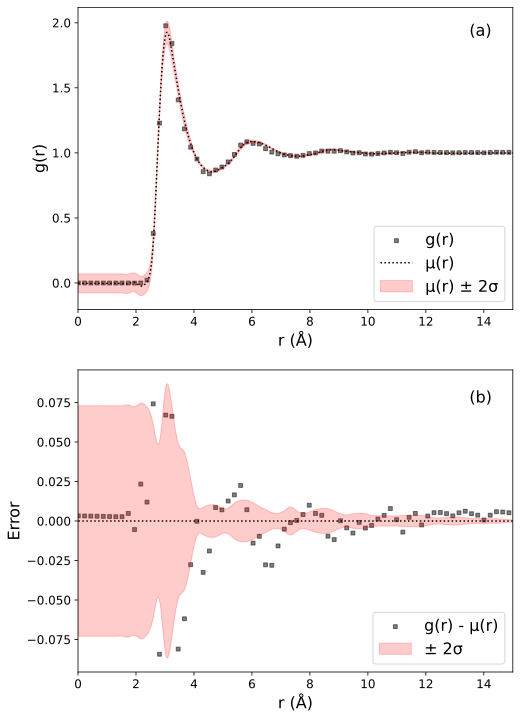

In [60]:
fig, ax = plt.subplots(2,1, figsize = (6.5*1.2,10*1.2))
ax[0].scatter(r, (rdf_exp - rdf_exp[0]), marker = 's', edgecolors = ['k'], 
              facecolors = ['k'], alpha = 0.5, label = 'g(r)', s =15)
ax[0].plot(r_smooth,μ_MCMC_smooth,label="μ(r)", color = 'k', linestyle = ':')
ax[0].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,
                   alpha=0.2, color ='r', label = 'μ(r) $\pm$ 2σ')
ax[0].legend(fontsize = '16', loc = 'lower right')
ax[0].set_xlabel('r (Å)', fontsize = 16)
ax[0].set_ylabel('g(r)', fontsize = 16)
ax[0].set_xlim(0,15)
ax[0].text(13.5, 1.9, '(a)', fontsize = 16)

#residuals plot
ax[1].scatter(r, rdf_exp - μ_MCMC - rdf_exp[0], marker = 's', edgecolors = ['k'], 
              facecolors = ['k'], alpha = 0.5, s = 15, label = 'g(r) - μ(r)')
ax[1].plot(r_smooth, np.zeros_like(r_smooth), color = 'k', linestyle = ':')
ax[1].fill_between(r_smooth,2*σ_MCMC_smooth, - 2*σ_MCMC_smooth,alpha=0.2, color = 'r', label = '$\pm$ 2σ')
ax[1].legend(fontsize = '16', loc = 'lower right')
ax[1].set_xlabel('r (Å)', fontsize = 16)
ax[1].set_ylabel('Error', fontsize = 16)
ax[1].set_xlim(0,15)
ax[1].text(13.5, 0.075, '(b)', fontsize = 16)
plt.savefig('post_predictive', dpi = 600)
plt.show()

# Posterior Plots

In [61]:
fig, ax = plt.subplots(2,3, figsize = (20,10))
bins_per_plot = 30

postSampsPlot = np.array(postSamps)

### n plotting ###

n_samps = postSampsPlot[:,0]

# Plot Settings
n_lim = [min(n_samps), max(n_samps)]
n_lim = [8.8, 10.8]
n_bins  = int(bins_per_plot*(max(n_samps) - min(n_samps))/(n_lim[-1] - n_lim[0]))
n_width = (max(n_samps) - min(n_samps))/n_bins
n_grid = torch.linspace(n_lim[0],n_lim[1],gridCount)

# Plot the PDF of thea prior
ax[0,0].plot(n_grid, log_prior_n(n_grid).exp(), color = '#440154')
ax[0,0].vlines(out['x'][0], 0, 1.5, color = 'r', linestyle = '--')
N, bins, patches = ax[0,0].hist(n_samps, bins = n_bins, density = True)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.cividis(norm(thisfrac))
    thispatch.set_facecolor(color)    
ax[0,0].set_xlim(n_lim[0],n_lim[1])
ax[0,0].set_xlabel('λ', fontsize = 16)
ax[0,0].set_ylabel('p(λ)', fontsize = 16)
ax[0,0].text(8.87, 1.35, '(a)', fontsize = 20)

### σ plotting ###
σ_samps = postSampsPlot[:,1]
σ_lim = [min(σ_samps), max(σ_samps)]
σ_lim = [2.76,2.8]
# Plot Settings
σ_bins = int(bins_per_plot*(max(σ_samps) - min(σ_samps))/(σ_lim[-1] - σ_lim[0]))
σ_width = (max(σ_samps) - min(σ_samps))/σ_bins
σ_grid = torch.linspace(σ_lim[0],σ_lim[1],gridCount)

# Plot the PDF of the prior
ax[0,1].plot(σ_grid, log_prior_σ(σ_grid).exp(), color = '#440154', label = 'Prior')
ax[0,1].vlines(out['x'][1], 0, 100, color = 'r', label = 'MAP', linestyle = '--')
N, bins, patches = ax[0,1].hist(σ_samps, bins = σ_bins, density = True)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.cividis(norm(thisfrac))
    thispatch.set_facecolor(color)    
ax[0,1].set_xlim(σ_lim[0],σ_lim[1])
ax[0,1].set_xlabel('σ', fontsize = 16)
ax[0,1].set_ylabel('p(σ)', fontsize = 16)
ax[0,1].legend(loc = 'upper right', fontsize = 20)
ax[0,1].text(2.762, 91, '(b)', fontsize = 20)

### ϵ plotting ###
ϵ_samps = postSampsPlot[:,2]
ϵ_lim = [min(ϵ_samps),max(ϵ_samps)]
ϵ_lim = [0.054,0.061]
# Plot Settings
ϵ_bins = int(bins_per_plot*(max(ϵ_samps) - min(ϵ_samps))/(ϵ_lim[-1] - ϵ_lim[0]))
ϵ_width = (max(ϵ_samps) - min(ϵ_samps))/ϵ_bins
ϵ_grid = torch.linspace(ϵ_lim[0],ϵ_lim[1],gridCount)

# Plot the PDF of the prior
ax[0,2].plot(ϵ_grid, log_prior_ϵ(ϵ_grid).exp(), color = '#440154')
ax[0,2].vlines(out['x'][2], 0, 500, color = 'r', label = 'MAP', linestyle = '--')
N, bins, patches = ax[0,2].hist(ϵ_samps, bins = ϵ_bins, density = True)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.cividis(norm(thisfrac))
    thispatch.set_facecolor(color)  
ax[0,2].set_xlim(ϵ_lim[0],ϵ_lim[1])
ax[0,2].set_xlabel('ϵ', fontsize = 16)
ax[0,2].set_ylabel('p(ϵ)', fontsize = 16)
ax[0,2].text(0.0543, 450, '(c)', fontsize = 20)

### 2D histograms ###

cmapname = 'cividis'

### n vs σ ###
ax[1,0].hexbin(n_samps, σ_samps, gridsize = (400,1800),cmap=cmapname)
ax[1,0].scatter(out['x'][0], out['x'][1], s = 200, color = 'r', marker = '+')
ax[1,0].set_xlim(n_lim)
ax[1,0].set_ylim(σ_lim)
ax[1,0].set_xlabel('λ', fontsize = 16)
ax[1,0].set_ylabel('σ', fontsize = 16)
ax[1,0].text(8.87, 2.795, '(d)', fontsize = 20, color = 'w')

### σ vs ϵ ###
ax[1,1].hexbin(σ_samps, ϵ_samps, gridsize = (2000,1600),cmap=cmapname)
ax[1,1].scatter(out['x'][1], out['x'][2], s = 200, color = 'r', marker = '+', label = 'MAP')
ax[1,1].set_xlim(σ_lim)
ax[1,1].set_ylim(ϵ_lim)
ax[1,1].set_xlabel('σ', fontsize = 16)
ax[1,1].set_ylabel('ϵ', fontsize = 16)
ax[1,1].text(2.762, 0.0602, '(e)', fontsize = 20, color = 'w')
ax[1,1].legend(loc = 'upper right', fontsize = 20)

### ϵ vs n ###
ax[1,2].hexbin(ϵ_samps, n_samps, gridsize = (2200,200),cmap=cmapname)
ax[1,2].scatter(out['x'][2], out['x'][0], s = 200, color = 'r', marker = '+')
ax[1,2].set_xlim(ϵ_lim)
ax[1,2].set_ylim(n_lim)
ax[1,2].set_xlabel('ϵ', fontsize = 16)
ax[1,2].set_ylabel('λ', fontsize = 16)
ax[1,2].text(0.0543, 10.58, '(f)', fontsize = 20, color = 'w')

# plt.savefig('posterior', dpi = 600)
plt.show()

In [62]:
# def se_dkernel(Kid,x1,x2,di,l):
#     import numpy as np
#     KidD = torch.zeros((len(x1), len(x2)))
#     for i in range (len(x1)):
#         for j in range (len(x2)):
#             KidD[i][j] = Kid[i][j] *(x2[j][di] - x1[i][di])/(l[di]**2)
#     return KidD

# Kid = se_kernel(Xi, Xd, l, w)
# derivKid = se_dkernel(Kid,Xi,Xd,0,l)
# KidKddInv = (derivKid @ KddInv)
# μ_n = (KidKddInv @ (y)).T

# derivKid = se_dkernel(Kid,Xi,Xd,1,l)
# KidKddInv = (derivKid @ KddInv)
# μ_σ = (KidKddInv @ (y)).T

# derivKid = se_dkernel(Kid,Xi,Xd,2,l)
# KidKddInv = (derivKid @ KddInv)
# μ_ϵ = (KidKddInv @ (y)).T

# μ_deriv_i      = interpolate.splrep(r,μ_n, s=0)
# μ_deriv_smooth_n = torch.from_numpy(interpolate.splev(r_smooth, μ_deriv_i , der=0))

# μ_deriv_i      = interpolate.splrep(r,μ_σ, s=0)
# μ_deriv_smooth_σ = torch.from_numpy(interpolate.splev(r_smooth, μ_deriv_i , der=0))

# μ_deriv_i      = interpolate.splrep(r,μ_ϵ, s=0)
# μ_deriv_smooth_ϵ = torch.from_numpy(interpolate.splev(r_smooth, μ_deriv_i , der=0))

# fig, ax = plt.subplots(3,1, figsize = (14,12),dpi=80)

# ax[0].plot(r_smooth,50*μ_deriv_smooth_n,label='50*dGP(r)/dn @ MAP Estimate')
# ax[0].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['k'], alpha = 0.1)
# ax[0].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['none'], label = 'g(r)')
# ax[0].plot(r_smooth,μ_MCMC_smooth,label="μ", color = 'k')
# ax[0].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,label="μ $\pm$ 2σ",alpha=0.2, color ='r')
# ax[0].set_title("50*dGP(r)/dn @ MAP Estimate")

# ax[1].plot(r_smooth,0.5*μ_deriv_smooth_σ,label='0.5*dGP(r)/dσ @ MAP Estimate')
# ax[1].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['k'], alpha = 0.1)
# ax[1].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['none'], label = 'g(r)')
# ax[1].plot(r_smooth,μ_MCMC_smooth,label="μ", color = 'k')
# ax[1].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,label="μ $\pm$ 2σ",alpha=0.2, color ='r')
# ax[1].set_title("0.5*dGP(r)/dσ @ MAP Estimate")

# ax[2].plot(r_smooth,0.2*μ_deriv_smooth_ϵ,label='0.2*dGP(r)/dϵ @ MAP Estimate')
# ax[2].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['k'], alpha = 0.1)
# ax[2].scatter(r, rdf_exp - rdf_exp[0], marker = 's', edgecolors = ['k'], facecolors = ['none'], label = 'g(r)')
# ax[2].plot(r_smooth,μ_MCMC_smooth,label="μ", color = 'k')
# ax[2].fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth, μ_MCMC_smooth - 2*σ_MCMC_smooth,label="μ $\pm$ 2σ",alpha=0.2, color ='r')
# ax[2].set_title("0.2*dGP(r)/dϵ @ MAP Estimate'")

# ax[2].set_xlabel('r (Å)', fontsize = 16)
# ax[1].set_ylabel('g(r)', fontsize = 16)
# plt.show()

In [63]:
# import matplotlib.pyplot as plt
# import numpy as np

# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (12,8))
# X = np.arange(2.74, 2.81, 0.0001)
# Y = np.arange(0.054, 0.063, 0.0001)
# X, Y = np.meshgrid(X, Y)
# R = 1/(2*np.pi*1.8*0.225)*np.exp(-(X - 2.778)**2/(2*1.8**2) - (Y-0.058)**2/(2*0.225**2))
# surf = ax.plot_surface(X, Y, R, cmap=cm.viridis,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel('σ', fontsize = 12)
# ax.set_ylabel('ϵ', fontsize = 12)
# ax.zaxis.set_major_locator(LinearLocator(5))
# ax.zaxis.set_major_formatter('{x:.01f}')
# ax.set_zlim(0,0.4)
# ax.set_zlabel('$p(σ, ϵ)$')
# plt.axis('off')
# plt.savefig('prior_toc', dpi = 600)
# plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (12,8))
# X = np.arange(2.74, 2.81, 0.0001)
# Y = np.arange(0.054, 0.063, 0.0001)
# X, Y = np.meshgrid(X, Y)
# R = 1/(2*np.pi*0.01*0.001)*np.exp(-(X - 2.779)**2/(2*0.01**2) - (Y-0.058)**2/(2*0.001**2))
# surf = ax.plot_surface(X, Y, R, cmap=cm.viridis,
#                        linewidth=0, antialiased=False)
# ax.set_xlabel('σ', fontsize = 12)
# ax.set_ylabel('ϵ', fontsize = 12)
# ax.zaxis.set_major_locator(LinearLocator(5))
# ax.zaxis.set_major_formatter('{x:.00f}')
# ax.set_zlabel('$p(σ, ϵ | RDF)$')
# plt.axis('off')
# plt.savefig('posterior_toc', dpi = 600)
# plt.show()

In [64]:
#plt.scatter(r_smooth[::8], μ_MCMC_smooth[::8], color = 'none', edgecolor = 'k', linewidth = 1, alpha = 1)
plt.scatter(r, (rdf_exp - rdf_exp[0]), marker = 's', edgecolors = ['k'], 
              facecolors = ['none'], alpha = 0.5, label = 'Experiment', s =15)
#plt.plot(r_smooth, μ_MCMC_smooth, label = 'g(r)', color = 'r', linewidth = 2)
# plt.plot(r_smooth[::6], μ_MCMC_smooth[::6], marker = '|', label="μ(r)", color = 'k', 
#          linestyle = '',markersize = 25, alpha = 0.75)
plt.fill_between(r_smooth,μ_MCMC_smooth+2*σ_MCMC_smooth + 0.03, μ_MCMC_smooth - 2*σ_MCMC_smooth - 0.03,
                   alpha=0.2, color ='r')
plt.plot(r_smooth, μ_MCMC_smooth, color = 'r', linestyle = '-', label = 'Local Gaussian Process')
#plt.axis('off')
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.xlim(2,)
plt.xlabel('r (Å)', fontsize = 18)
plt.ylabel('g(r)', fontsize = 18)
plt.legend(fontsize = 16)
# plt.savefig('lgp_toc', dpi = 600)
plt.show()